In [1]:
import sys
import platform
from os.path import join, exists, abspath, dirname
from os import getcwd, makedirs, remove
from glob import glob

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm
from matplotlib import colors as mcolors
import scipy
from scipy.stats import kendalltau
from scipy.stats import ttest_1samp, pearsonr, ttest_rel
from scipy.io import loadmat
from sklearn.metrics import r2_score
from statsmodels.stats.anova import AnovaRM
import seaborn as sns
import h5py

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting, image
from nipype.interfaces import fsl

In [3]:
from nilearn.mass_univariate import permuted_ols

In [4]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/home/sungbeenpark/github'

In [5]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [6]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [7]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [8]:
dname = join(dir_git,'Functional_Fusion')
sys.path.append(dname)
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

In [9]:
dname = join(dir_git,'AnatSearchlight')
sys.path.append(dname)
import AnatSearchlight.searchlight as sl

In [10]:
dname = abspath(join(dir_git,'PcmPy'))
sys.path.append(dname)
import PcmPy as pcm

In [11]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import stat as sstat
from SSS import plot as splt
from SSS import image as simage
from SSS import glmsingle as ssingle

---

In [12]:
mpl.rcParams['font.family'] = 'Helvetica'

### Font를 못 읽어 온다면, matplotlib 캐시 초기화
`rm -rf ~/.cache/matplotlib`

---

In [13]:
hem = 'L'

In [14]:
list_sn = su.get_list_sn()

---

In [15]:
glm = 1
dir_glm = ssingle.get_dir_glmsingle(glm)
dir_glm

'/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/glm_1'

In [16]:
dir_surf = join(ssingle.get_dir_glmsingle(),'surfaceWB')
dir_surf

'/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/surfaceWB'

In [17]:
dir_group = join(dir_surf,'group')

---

## Define matrices

In [18]:
## re-arranged index
idx_arr = [0,2,4,6,1,3,5,7]

In [19]:
def return_mat(model):
    N = 8
    mat = np.ones((N,N)) * np.nan
    mat_arr = np.ones((N,N)) * np.nan
    for row in range(N):
        for col in range(N):
            if model == 'letter':
                ## 4. letter
                if (row%2==0)&(col%2==0):
                    mat[row,col] = 1
            elif model == 'spatial':
                ## 5. spatial
                if (row%2==1)&(col%2==1):
                    mat[row,col] = 1
            elif model == 'across':
                ## 6. across cue
                if (row==col-1)&(row%2==0):
                    mat[row,col] = -1
                elif (row%2==0)&(col%2==1)&(row+1!=col):
                    mat[row,col] = 1
                    
    
    ## post-processing
    mat_arr = np.copy(mat)
    mat_arr = mat_arr[idx_arr][:,idx_arr]
    for row in range(N):
        for col in range(N):
            if row==col:
                mat[row,col] = np.nan
                mat_arr[row,col] = np.nan

    ## noramlize
    idx = np.copy(mat>0)
    mat[idx] /= idx.sum()
    idx = np.copy(mat<0)
    mat[idx] /= idx.sum()

    idx = np.copy(mat_arr>0)
    mat_arr[idx] /= idx.sum()
    idx = np.copy(mat_arr<0)
    mat_arr[idx] /= idx.sum()

    return mat, mat_arr

---
---

## Model RDM for across-cue (ranked correlation)

In [25]:
# def return_mat_model(model):
#     N = 8
#     mat_model = np.ones((N,N)) * np.nan
#     for row in range(N):
#         for col in range(N):
#             if model=='letter':
#                 if (row<4)&(col<4):
#                     if row==col:
#                         mat_model[row][col] = 0
#                     else:
#                         mat_model[row][col] = 1
#             elif model=='spatial':
#                 if (row>=4)&(col>=4):
#                     if row==col:
#                         mat_model[row][col] = 0
#                     else:
#                         mat_model[row][col] = 1
#             elif model=='across':
#                 if (row<4)&(col>=4):
#                     if row+4==col:
#                         mat_model[row][col] = 0
#                     else:
#                         mat_model[row][col] = 1
    
#     return mat_model

In [26]:
# mat_model = return_mat_model(model)
# g = sns.heatmap(mat_model, vmin=-1, vmax=1, annot=True, cmap=cmap)
# g.set_xticklabels(conditions)
# g.set_yticklabels(conditions)

In [27]:
def vec_upper_tri(mat, k=1):
    N = mat.shape[0]
    idx = np.triu_indices(N, k=k) # k=1 : off-diagonal sum
    return mat[idx]

---
---

## Run Searchlight

In [21]:
# model = 'diff_cue'
# model = 'finger_same-diff'
# model = 'finger_diff'
# model = 'letter'
# model = 'spatial'
model = 'across'

In [20]:
reginfo = deal_spm.load_reginfo(subj='S01', dir_glm=dir_glm)
conditions = np.array(sorted(reginfo.name.unique()))

[Text(0, 0.5, '(1,L)'),
 Text(0, 1.5, '(2,L)'),
 Text(0, 2.5, '(3,L)'),
 Text(0, 3.5, '(4,L)'),
 Text(0, 4.5, '(1,S)'),
 Text(0, 5.5, '(2,S)'),
 Text(0, 6.5, '(3,S)'),
 Text(0, 7.5, '(4,S)')]

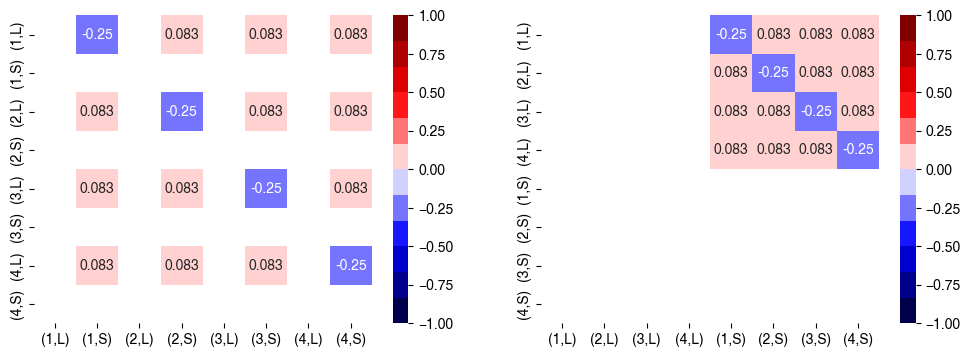

In [23]:
mat, mat_arr = return_mat(model)

cmap = cm.seismic.resampled(12)
fig, axs = plt.subplots(ncols=2, figsize=(12,4))
ax = axs[0]
sns.heatmap(mat, vmin=-1, vmax=1, annot=True, cmap=cmap, ax=ax)
ax.set_xticklabels(conditions)
ax.set_yticklabels(conditions)
ax = axs[1]
sns.heatmap(mat_arr, vmin=-1, vmax=1, annot=True, cmap=cmap, ax=ax)
ax.set_xticklabels(conditions[idx_arr])
ax.set_yticklabels(conditions[idx_arr])

In [24]:
print(np.nansum(mat[mat>0]), np.nansum(mat[mat<0]))
assert np.nansum(mat[mat>0])==1
assert (np.nansum(mat[mat<0])==-1)|(np.nansum(mat[mat<0])==0)

1.0 -1.0


In [28]:
# Define the MVPA function that will be used in the searchlight
# The functions take a n_images x n_voxels array as input.
# and return either a scalar or vector as output.
# Here we use simple example that calculate the mean activity in the searchlight region.
def func_Dist(data, **kwargs):
    obs_des = {
        'cond_vec': kwargs['cond_vec'],
        'part_vec': kwargs['part_vec'],
        # 'cue': kwargs['cue']
    }
    
    ## set the dataset
    Y = pcm.dataset.Dataset(
        measurements=data,
        obs_descriptors=obs_des
    )
    ## the second moment matrix G
    G_hat, _ = pcm.est_G_crossval(
        Y=Y.measurements,
        Z=Y.obs_descriptors['cond_vec'],
        part_vec=Y.obs_descriptors['part_vec'],
        X=pcm.matrix.indicator(Y.obs_descriptors['part_vec'])
    )
    dist = pcm.G_to_dist(G_hat)
    
    ## i) get the average distance
    tmp = dist * mat
    result = np.nansum(tmp)

    ## ii) Kendall's tau
    # vec1 = vec_upper_tri(dist)
    # vec2 = vec_upper_tri(mat_model)
    # tau, pval = kendalltau(vec1, vec2, variant='b', nan_policy='omit')
    # result = tau
    
    return result

In [29]:
def getback_vec(reginfo):
    part_vec = reginfo.run.values
    cond_vec = np.array(
        [
            2*(int(num)-1) + (0 if ch == "L" else 1) + 1
            for num, ch in (item.strip("()").split(",") for item in reginfo.name)
        ]
    )
    return part_vec, cond_vec

In [30]:
# reginfo = deal_spm.load_reginfo(subj='S01', dir_glm=dir_glm)
# reginfo

In [31]:
dir_output = join(dir_surf,'glm_%1d'%glm)
exists(dir_output)

True

In [32]:
for ii, sn in enumerate(tqdm(list_sn)):
    subj = 'S'+sn

    ## We can now use the pre-computed searchlight.
    nvoxel = 200
    fname = join(su.get_dir_surf(),subj,'%s.%s.searchlight_surface.nvoxel=%d.h5'%(subj,hem,nvoxel))
    mySearchlight = sl.load(fname)
    # print(f'Average size of the searchlight: {mySearchlight.radius.mean():.1f} mm')
    # print(f'Average number of voxels: {mySearchlight.nvoxels.mean():.1f}')
    
    dir_work = join(dir_glm,'surfaceWB',subj)

    ## load reginfo.tsv
    reginfo = deal_spm.load_reginfo(subj=subj, dir_glm=dir_glm)
    part_vec, cond_vec = getback_vec(reginfo)
    obs_des = {
        'part_vec': part_vec, 'cond_vec': cond_vec,
        # 'cue':cue
    }

    ## set betas
    dataset = [join(dir_glm,subj,'beta_%04d.nii'%(ii+1)) for ii in range(len(cond_vec))]
    
    ## Run the searchlight with the defined scalar MVPA function
    results = mySearchlight.run(dataset, func_Dist, obs_des, verbose=False)

    ## save the result
    fname = join(dir_output,subj,'%s.%s.glm_%d.searchlight.mean_dist.%s.dscalar.nii'%(subj,hem,glm,model))
    if exists(fname):
        remove(fname)
    mySearchlight.data_to_cifti(results, outfilename=fname)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [57:49<00:00, 289.15s/it]


---

### Make the group result

### Load individual data

In [33]:
dataset = np.ones((len(list_sn),32492)) * np.nan
for ii, sn in enumerate(tqdm(list_sn)):
    subj = 'S'+sn

    ## load the result
    fname = join(dir_surf,'glm_%1d'%glm,subj,'%s.%s.glm_%d.searchlight.mean_dist.%s.dscalar.nii'%(subj,hem,glm,model))
    # if not exists(fname):
    #     continue
    cifti = nb.load(fname)
    
    ## load the setup file
    # nvoxel = 100 if not subj=='S02' else 70
    nvoxel = 200
    fname = join(su.get_dir_surf(),subj,'%s.%s.searchlight_surface.nvoxel=%d.h5'%(subj,hem,nvoxel))
    mySearchlight = sl.load(fname)

    ## check the indeces of centers
    idx = mySearchlight.center_indx
    dataset[ii,idx] = cifti.get_fdata()
    
    del cifti, mySearchlight

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:50<00:00,  4.24s/it]


### Save the dataset as cifti

In [34]:
dir_output = join(dir_surf,'glm_%1d'%glm)
simage.save_surf2cifti(
    data=dataset,
    dir_output=dir_output,
    label_axis=['S'+sn for sn in list_sn],
    prefix='cifti.%s.glm_%1d.searchlight.mean_dist.%s'%(hem,glm,model)
)

### Permutation test to define t-test

In [35]:
## one-sample test: constant predictor
tested_vars = np.ones((12, 1))

In [36]:
fname = join(dir_surf,'glm_%1d'%glm,'cifti.%s.glm_%1d.searchlight.mean_dist.%s.dscalar.nii'%(hem,glm,model))
data = nb.load(fname).get_fdata()

In [37]:
## permutation test
res = permuted_ols(
    tested_vars=tested_vars,
    target_vars=data,
    n_perm=10000,
    two_sided_test=True,
    n_jobs=1,
    output_type="dict"
)
tmap = res['t'].reshape(-1)

In [38]:
dataset = np.ones((2,32492)) * np.nan
dataset[0,:] = np.mean(data, axis=0)
dataset[1,:] = tmap
simage.save_surf2cifti(
    data=dataset,
    dir_output=dir_group,
    label_axis=['mean','t'],
    prefix='cifti.%s.glm_%1d.searchlight.mean_dist.%s'%(hem,glm,model)
)

---
---

## Plot the result

In [25]:
dir_work = join(dir_group)
# glob(join(dir_work,'*mean_dist*'))

100%|█████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.27it/s]


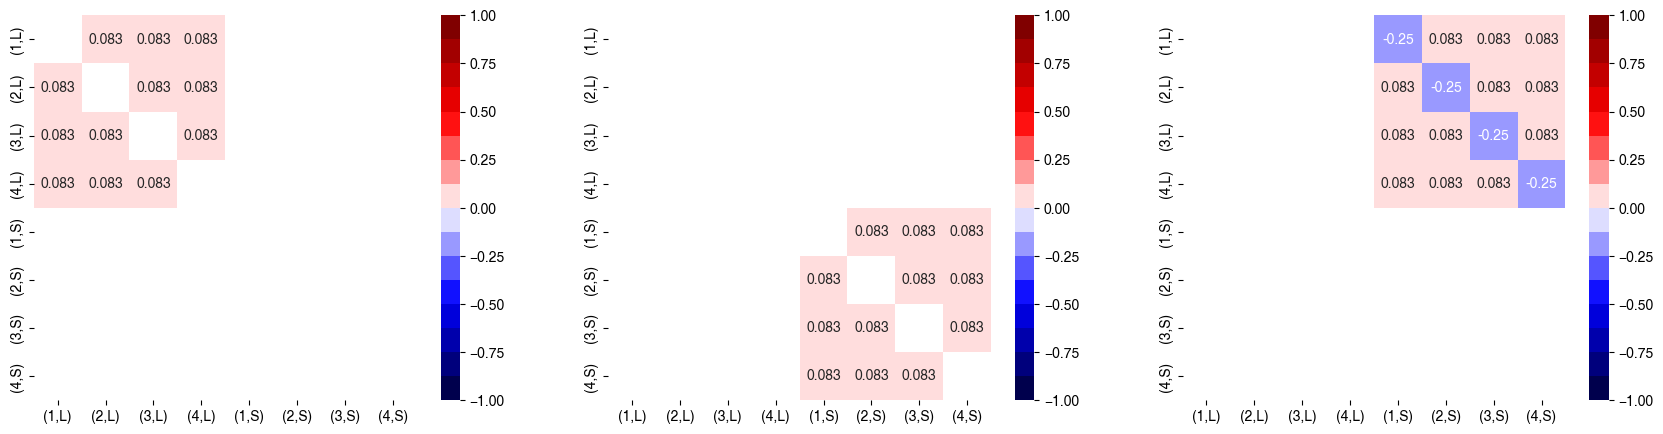

In [26]:
ncols, nrows = 3,1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7*ncols,5*nrows))

for ii, model in enumerate(tqdm(['letter', 'spatial', 'across'])):
    ## plot matrix
    ax = axs[ii]
    mat, mat_arr = return_mat(model)
    g = sns.heatmap(mat_arr, cmap=cm.seismic.resampled(16), annot=True, vmin=-1, vmax=1, ax=ax)
    g.set_xticklabels(conditions[idx_arr])
    g.set_yticklabels(conditions[idx_arr])

---

In [19]:
alternative = 'one-sided'
thresh = sstat.convert_alpha_to_tval(alpha=0.05, df=len(list_sn)-1, alternative=alternative)
thresh

np.float64(1.7958848187036691)

In [75]:
def get_RDM(model, thresh=None):
    fname = join(dir_work,'cifti.%s.glm_%1d.searchlight.mean_dist.%s.dscalar.nii'%(hem,glm,model))
    data = np.array(nb.load(fname).get_fdata())
    ds = data[0].copy()
    if not thresh==None:
        ## thresholding
        idx = data[1] >= thresh
        ds[~idx] = np.nan

    return ds

In [47]:
for model in ['letter','spatial','across']:
    ds = get_RDM(model=model, thresh=thresh)
    
    x = np.nanmin(np.abs(ds))
    y = np.nanmax(np.abs(ds))
    print(model, '[%f, %f]'%(x,y))

letter [0.002353, 0.069400]
spatial [0.002071, 0.233001]
across [0.001922, 0.072526]


In [49]:
vmin, vmax = 0.0019, 0.23
ttt = vmin
cscale = [vmin, vmax]

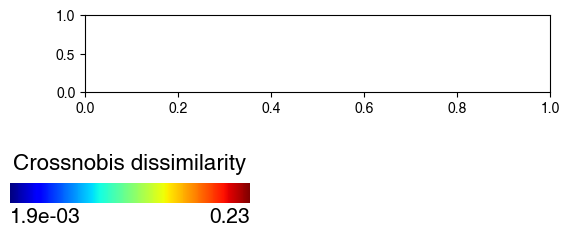

In [50]:
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
sm = cm.ScalarMappable(cmap=cm.jet, norm=norm)
sm.set_array([])

fig, ax = plt.subplots(figsize=(6, 1))
cax = fig.add_axes(rect=[0, -1, 0.4, 0.2])

cbar = fig.colorbar(sm, cax=cax, location='bottom', orientation='horizontal')
cbar.ax.tick_params(labelsize=13)
# cbar.set_label('Crossnobis dissimilarity', fontsize=16, loc='center')
cbar.ax.set_title('Crossnobis dissimilarity', fontsize=16, pad=10)

for spine in cbar.ax.spines.values():
    spine.set_visible(False)
cbar.ax.tick_params(size=0, labelsize=15)   # tick 선 길이 제거
ticks = [ttt, vmax]
cbar.set_ticks(ticks)
cbar.ax.set_xticklabels(['%.1e'%tick if ii==0 else '%.2f'%tick for ii, tick in enumerate(ticks)])
# cbar.ax.tick_params(labelsize=0)  # tick 라벨 제거

for ii, label in enumerate(cbar.ax.get_xticklabels()):
    ha = 'center'
    if ii==0:
        ha = 'left'
    elif ii==len(ticks)-1:
        ha = 'right'
    label.set_ha(ha)

In [51]:
fig.savefig(
    join('/mnt/f/SeqSpatialSupp_fMRI/cbar.png'),
    dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
)

In [ ]:
border, brdr = simage.get_border(dir_git=dir_git, atlas='sulcus')
# border, brdr = simage.get_border(dir_git=dir_git, atlas='Glasser')

100%|█████████████████████████████████████████████████████| 3/3 [00:11<00:00,  3.85s/it]


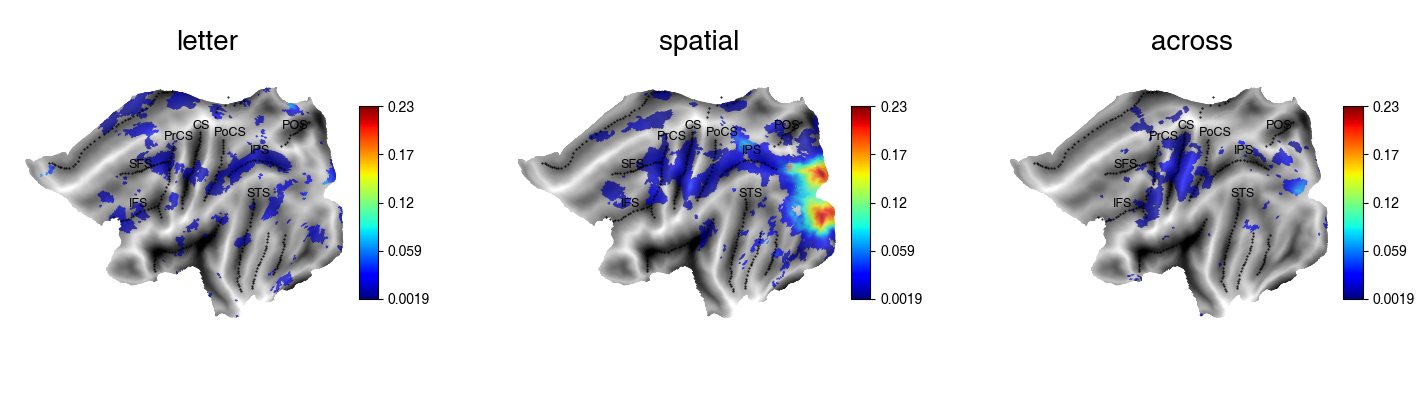

In [52]:
ncols, nrows = 3,1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols,5*nrows))

for ii, model in enumerate(tqdm(['letter', 'spatial', 'across'])):
    plt.sca(axs[ii])

    ds = get_RDM(model, thresh=thresh)
    # ds = get_RDM(model); ds[ds<vmin] = np.nan

    color = 'black'
    g = surf.plot.plotmap(
        data=ds,
        surf='fs32k_%s'%hem,
        alpha=0.7,
        cmap=cm.jet, colorbar=True,
        cscale=cscale,
        # threshold=thresh,
        borders=border, bordercolor=color, bordersize=1,
        overlay_type='func', render='matplotlib',
    )
    g.text(x=40, y=250, s=model, ha='center', va='center', fontsize=20)
    for line, (x, y) in brdr.items():
        g.text(x=x, y=y, s=line, ha='left', va='bottom', color=color, fontsize=9)

In [34]:
fig.savefig(
    join('/mnt/f/SeqSpatialSupp_fMRI/RDM_flat.png'),
    dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
)

100%|█████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.26it/s]


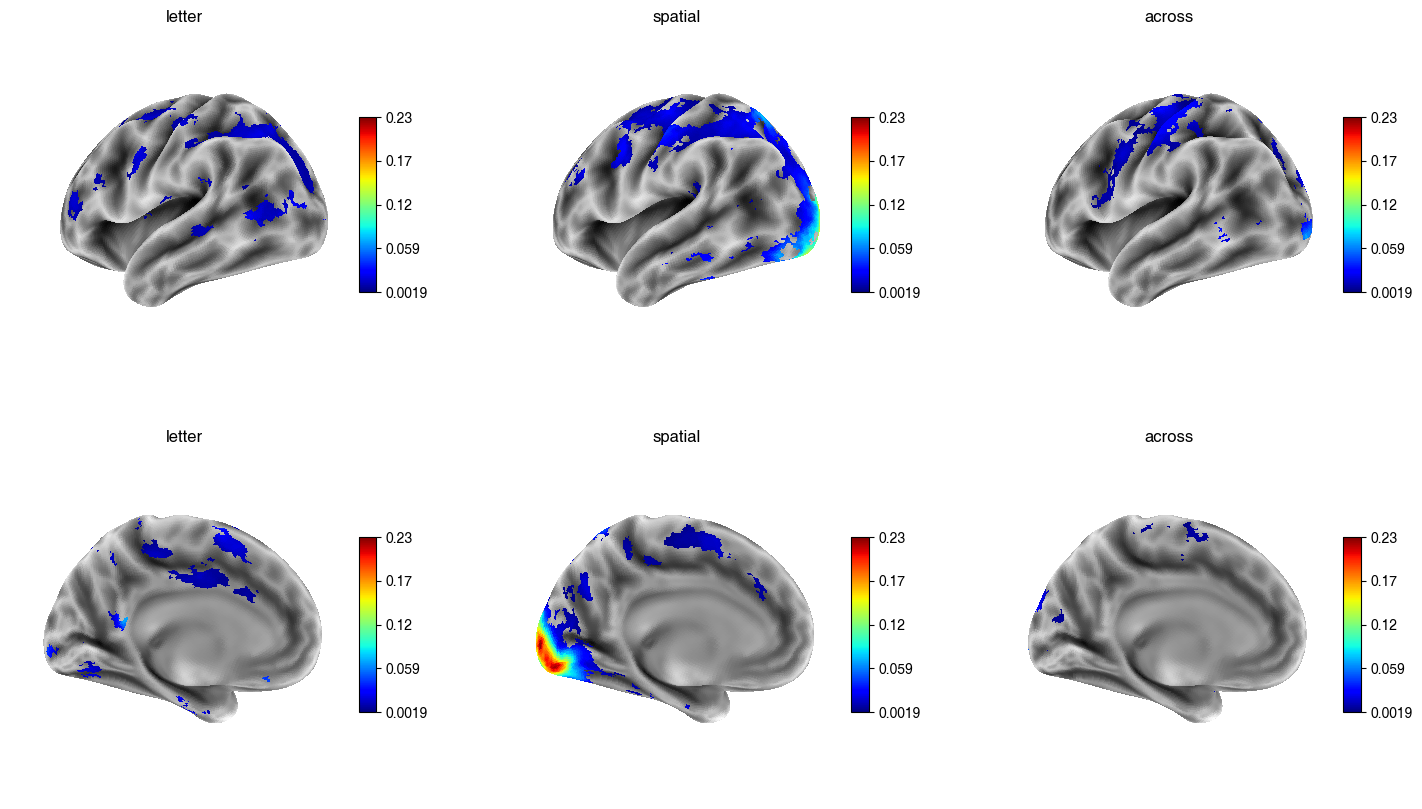

In [35]:
ncols, nrows = 3,2
fig, axs = plt.subplots(
    nrows=nrows, ncols=ncols,
    figsize=(6*ncols,5*nrows),
    subplot_kw={'projection': "3d"}
)
# mesh = join(dir_git,'fs_LR_32/fs_LR.32k.L.pial.surf.gii')
mesh = join(dir_git,'fs_LR_32/fs_LR.32k.L.inflated.surf.gii')
sulc = join(su.get_dir_surf(),'S01/S01.L.sulc.32k.shape.gii')
for ii, model in enumerate(tqdm(['letter', 'spatial', 'across'])):
    ax = axs[0,ii]
    
    ds = get_RDM(model, thresh=thresh)
    
    elev, azim = 0, 200
    g = plotting.plot_surf(
        surf_map=ds,
        surf_mesh=mesh, bg_map=sulc,
        cmap=cm.jet, colorbar=True,
        vmin=cscale[0],vmax=cscale[1],
        cbar_vmin=cscale[0], cbar_vmax=cscale[1],
        hemi='left', view=(elev, azim),
        darkness=None,
        title=model,
        axes=ax
    )

    ax = axs[1,ii]
    elev, azim = 0, 0
    g = plotting.plot_surf(
        surf_map=ds,
        surf_mesh=mesh, bg_map=sulc,
        cmap=cm.jet, colorbar=True,
        vmin=cscale[0],vmax=cscale[1],
        cbar_vmin=cscale[0], cbar_vmax=cscale[1],
        hemi='left', view=(elev, azim),
        darkness=None,
        title=model,
        axes=ax
    )

In [36]:
fig.savefig(
    join('/mnt/f/SeqSpatialSupp_fMRI/RDM_inflated.png'),
    dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
)

---
---

## ROI Mask

In [20]:
dir_roi = su.get_dir_roi()

In [21]:
border, brdr = simage.get_border(dir_git=dir_git, atlas='sulcus')
# border, brdr = simage.get_border(dir_git=dir_git, atlas='Glasser')

In [22]:
fname = join(dir_roi,'SPark2025.32k.L.label.gii')
gii = nb.load(fname)
mask = gii.darrays[0].data

In [23]:
list_roi = []
for ii, label in enumerate(gii.labeltable.labels):
    if ii>0:
        list_roi.append(label.label)
list_roi = np.array(list_roi)
list_roi

array(['SMA', 'M1', 'PMd', 'PMv', 'SPLa', 'SPLp', 'V4d', 'Vf', 'Vv',
       'TPOJ'], dtype='<U4')

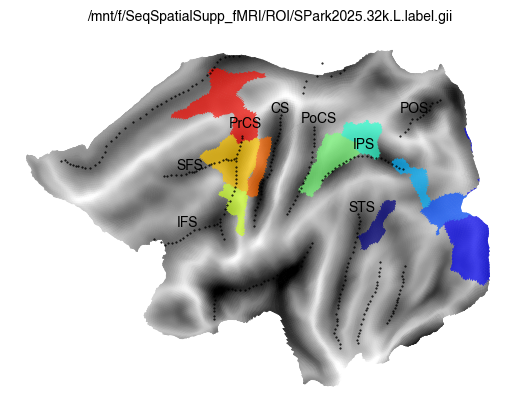

In [24]:
g = surf.plot.plotmap(
    data=mask,
    surf='fs32k_%s'%hem,
    alpha=0.7,
    cmap=cm.jet_r.resampled(len(np.unique(mask))),
    # colorbar=True,
    # cscale=[-1,7],
    # threshold=[-thresh,thresh],
    borders=border, bordercolor='black', bordersize=1,
    overlay_type='func', render='matplotlib',
)
g.text(x=20, y=220, s=fname, ha='center', va='center', fontsize=10)
for line, (x, y) in brdr.items():
    g.text(x=x, y=y, s=line, ha='left', va='bottom', color='black', fontsize=10)

In [25]:
def extract_data(data, mask, list_roi):
    result = {}
    for ii, roi in enumerate(list_roi):
        assert data.shape[-1] == mask.shape[0]
        val = ii+1
        idx = mask==val

        result[roi] = data[:,idx].mean(axis=-1)

    return result

---

In [26]:
dir_work = join(dir_surf,'glm_%1d'%glm)
dir_work

'/mnt/f/SeqSpatialSupp_fMRI/GLMsingle/surfaceWB/glm_1'

In [27]:
lines = {'roi':[],'cond':[],'subj':[],'value':[]}

In [28]:
for ii, cue in enumerate(['letter','spatial','across']):
    fname = join(dir_work,'cifti.%s.glm_%1d.searchlight.mean_dist.%s.dscalar.nii'%(hem,glm,cue))
    data = np.array(nb.load(fname).get_fdata())
    res = extract_data(data=data, mask=mask, list_roi=list_roi)
    for roi, values in res.items():
        for kk, value in enumerate(values):
            sn = list_sn[kk]
            subj = 'S'+sn
            lines['roi'].append(roi)
            lines['cond'].append(cue)
            lines['subj'].append(subj)
            lines['value'].append(value)
df = pd.DataFrame(lines)

In [29]:
df

,roi,cond,subj,value
0,SMA,letter,S01,0.020778
1,SMA,letter,S02,-0.000653
2,SMA,letter,S03,-0.004369
3,SMA,letter,S05,0.000950
4,SMA,letter,S06,0.004430
...,...,...,...,...
355,TPOJ,across,S10,0.003164
356,TPOJ,across,S11,-0.001665
357,TPOJ,across,S12,0.005479
358,TPOJ,across,S13,-0.006988


SMA
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  0.6946 2.0000 22.0000 0.5099

letter: t(11)=1.8357, p=4.678e-02(*)
spatial: t(11)=2.5683, p=1.306e-02(*)
M1
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  1.9891 2.0000 22.0000 0.1607

spatial: t(11)=2.9742, p=6.325e-03(**)
across: t(11)=3.9271, p=1.182e-03(**)
PMd
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  0.9808 2.0000 22.0000 0.3908

letter: t(11)=2.0235, p=3.400e-02(*)
spatial: t(11)=4.4811, p=4.648e-04(***)
across: t(11)=2.0658, p=3.162e-02(*)
PMv
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond  0.3783 2.0000 22.0000 0.6894

letter: t(11)=1.8853, p=4.303e-02(*)
spatial: t(11)=4.9473, p=2.187e-04(***)
across: t(11)=3.1176, p=4.896e-03(**)
SPLa
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cond 

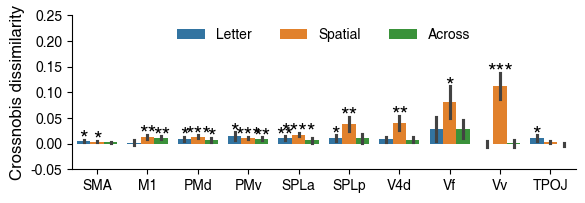

In [32]:
fig, ax = plt.subplots(figsize=(6.5,2))

# rois = ['PMd','PMv','M1','SPLa','SPLp','TPOJ']
rois = list_roi
conds = ['letter','spatial','across']
data = df[df['roi'].isin(rois)]
g = sns.barplot(
    data=data,
    x='roi', order=rois,
    y='value',
    hue='cond', hue_order=conds,
    errorbar='se', capsize=0.,
    ax=ax
)
handles, labels = plt.gca().get_legend_handles_labels()
g.legend(
    handles, 
    ['Letter','Spatial','Across'],
    loc='upper center', ncols=3,
    frameon=False,
    fontsize=10
)

g.set_xlabel('')
xticks = g.get_xticks()
g.set_xticks(xticks)
g.set_xticklabels(rois, fontsize=10)

g.set_ylabel('Crossnobis dissimilarity', fontsize=12)
g.set_ylim([-0.01,0.21])
yticks = g.get_yticks()
g.set_yticks(yticks)
g.set_yticklabels(['%.2f'%y for y in yticks], fontsize=10)
ylim = np.array(g.get_ylim())
dy = np.diff(ylim)[0]*0.05

g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)

for ii, roi in enumerate(rois):
    print(roi)
    aov = AnovaRM(
        data=data[data.roi==roi],
        depvar='value',
        subject='subj',
        within=['cond']
    ).fit()
    print(aov)
    for jj, cond in enumerate(conds):
        ## one sample t-test
        a = data[(data.roi==roi)&(data.cond==cond)].value.astype(float)
        res = ttest_1samp(a, popmean=0, alternative='greater')
        pval = res.pvalue
        if pval<0.05:
            print('%s: t(%d)=%.4f, p=%.3e(%s)'%(cond,res.df,res.statistic,pval,sstat.convert_pval_to_star(pval)))
            x = ii + 0.275*(jj-1)
            y = a.mean() + a.sem()
            g.text(
                x=x, y=y,
                s=sstat.convert_pval_to_star(pval), fontsize=16,
                color='black',
                ha='center', va='center'
            )
        for kk, cond2 in enumerate(conds[jj+1:]):
            ## paired t-test
            b = data[(data.roi==roi)&(data.cond==cond2)].value.astype(float)
            res = ttest_rel(a, b, alternative='two-sided')
            pval = res.pvalue
            if pval<0.05:
                print('%s vs. %s: t(%d)=%.4f, p=%.3e(%s)'%(cond, cond2,res.df,res.statistic,pval,sstat.convert_pval_to_star(pval)))

In [33]:
fig.savefig(
    join('/mnt/f/SeqSpatialSupp_fMRI/ROI_analysis.png'),
    dpi=300, facecolor=[1,1,1,1], bbox_inches = "tight"
)

---
---

## Individual plotting

In [43]:
def plot_cue(cue):

    fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(5*4,4*3))
    axs = np.concatenate(axs)
    
    for ii, sn in enumerate(tqdm(list_sn)):
        ax = axs[ii]
        plt.sca(ax)
    
        subj = 'S'+sn
        dir_work = join(dir_surf,'glm_%1d'%glm,subj)
        
        fname = join(su.get_dir_surf(),subj,'%s.%s.searchlight_surface.nvoxel=200.h5'%(subj,hem))
        mySearchlight = sl.load(fname)
        
        ## check the indeces of centers
        idx = mySearchlight.center_indx
        
        data = np.zeros(32492)
        
        fname = join(dir_work, '%s.%s.glm_%1d.searchlight.mean_dist.%s.dscalar.nii'%(subj,hem,glm,cue))
        cii = nb.load(fname)
        data[idx] = np.array(cii.get_fdata()[0])
        
        # vmax = max(abs(data.min()), data.max())
        vmax = 0.23
        vmin = -0.0019
        
        color = 'black'
        g = surf.plot.plotmap(
            data=data,
            surf='fs32k_%s'%hem,
            alpha=0.7,
            cmap=cm.seismic, colorbar=True,
            cscale=[vmin, vmax],
            # threshold=[-thresh,thresh],
            borders=border, bordercolor=color, bordersize=1,
            overlay_type='func', render='matplotlib',
        )
        g.text(x=40, y=250, s=subj, ha='center', va='center', fontsize=20)
        for line, (x, y) in brdr.items():
            g.text(x=x, y=y, s=line, ha='left', va='bottom', color=color, fontsize=9)
        fig.suptitle(cue, fontsize=24)

In [45]:
cue = 'letter'
plot_cue(cue)

In [ ]:
cue = 'spatial'
plot_cue(cue)

---